In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib

# setting plot size
%pylab inline
pylab.rcParams['figure.figsize'] = (16, 9)

Populating the interactive namespace from numpy and matplotlib


In [2]:
%run ./feature_engineering.py
%run ./utils.py

# 0. IMPORTING DATA

In [4]:
GLE = get_df("GLE.PA.csv")

In [5]:
print_info_stock(GLE)

nom      : Adj Close
min date : 2000-01-03
max date : 2018-01-30
nb dates : 4653
null     : 6


In [6]:
GLE[GLE.isnull()]
GLE = GLE[GLE.notnull()] # some rows have no value for the adjusted close, we delete those rows

# 1. FEATURE ENGINEERING
obj = predict cumulative @ today + 5 five trading days

**FEATURES USED** <br>
explained in features.txt

** DO SOMETHING ABOUT THE VOLUMES **

In [7]:
GLE = build_df("GLE.PA.csv")

# 2. ML

In [9]:
X_train, X_test, Y_train, Y_test = split_train_test(GLE)

from sklearn.ensemble import RandomForestRegressor
clf = RandomForestRegressor()
clf.fit(X_train,Y_train)
Y_pred = pd.Series(clf.predict(X_test))
Y_pred.index = Y_test.index

/Users/edouardcuny/.pyenv/versions/2.7.10/envs/ml/lib/python2.7/site-packages/pandas/core/indexing.py:601: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item_labels[indexer[info_axis]]] = value


# 3. RESULTS

In [11]:
X_train.head(10)

,in_BB,pr_in_BB,out_to_in_BB,spike,pr_spike,spike_derivative,crossed_RM_up,crossed_RM_down,mom_1,mom_5,...,ema9_of_ema_diff,macad,pr_macad,macad_derivative,Kfast,Dfast,Dslow,LWR,CMF,SMI
Date,,,,,,,,,,,,,,,,,,,,,
2000-02-08,1.0,1.0,0.0,-0.224608,-0.281953,0.110715,0.0,0.0,0.111885,-0.590043,...,0.529387,-0.109392,-0.203550,0.345827,-0.723327,-0.778432,-0.585912,0.723327,-2.838816,-1.974333
2000-02-09,1.0,1.0,0.0,-0.669492,-0.223045,-0.859896,0.0,0.0,-0.934068,-1.196623,...,0.520238,-0.078057,-0.111149,0.121631,-1.557689,-1.116727,-0.879958,1.557689,-2.875731,-1.898126
2000-02-10,1.0,1.0,0.0,-0.504927,-0.667733,0.314215,0.0,0.0,0.302903,-0.651689,...,0.513583,0.054993,-0.079834,0.494712,-0.968913,-1.157391,-1.045367,0.968913,-2.437265,-1.831139
2000-02-11,1.0,1.0,0.0,-0.350227,-0.503240,0.295208,0.0,0.0,0.300160,-0.210397,...,0.517517,0.078402,0.053134,0.092561,-0.690111,-1.145529,-1.171406,0.690111,-2.474212,-1.789429
2000-02-14,1.0,1.0,0.0,-0.664676,-0.348609,-0.608611,0.0,0.0,-0.645651,-0.379748,...,0.523314,0.031695,0.076529,-0.164620,-1.247715,-1.034832,-1.143288,1.247715,-2.471684,-1.754900
2000-02-15,1.0,1.0,0.0,-0.625929,-0.662919,0.071825,0.0,0.0,-0.111024,-0.474303,...,0.525393,0.070029,0.029851,0.147302,-1.329735,-1.163688,-1.145450,1.329735,-2.278974,-1.719551
2000-02-16,1.0,1.0,0.0,-0.092840,-0.624188,1.024179,0.0,0.0,0.888489,0.316587,...,0.530524,0.087524,0.068161,0.070868,-0.542523,-1.110981,-1.133588,0.542523,-1.791124,-1.697982
2000-02-17,1.0,1.0,0.0,0.443213,-0.091334,1.029887,1.0,0.0,0.921884,0.589440,...,0.537047,-0.040713,0.085645,-0.463665,0.293883,-0.560446,-0.970713,-0.293883,-1.569849,-1.689627
2000-02-18,1.0,1.0,0.0,0.457040,0.444482,0.023817,0.0,0.0,-0.088685,0.415153,...,0.533364,-0.260909,-0.042513,-0.800959,0.228314,-0.004037,-0.572558,-0.228314,-1.274196,-1.671413


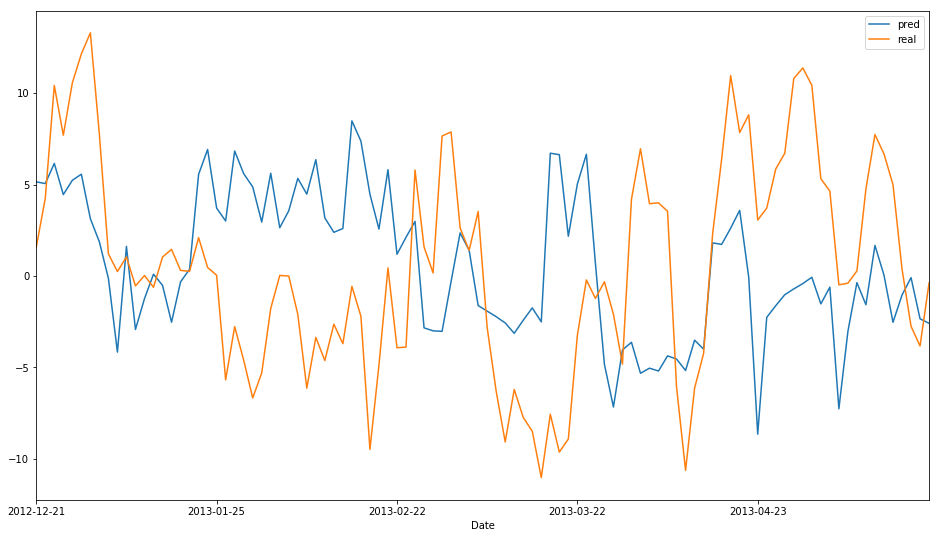


50% of the time we get the direction right

MAE TEST  : 4.31351430752
MSE TEST  : 36.9917517448


In [10]:
print_results_report(Y_pred,Y_test)

# 4. LEARNING CURVE 

We use a learning curve to diagnose what went wrong.

In [ ]:
compute_learning_curve(clf,X_train,Y_train)

# MORE DATA

In [12]:
# i want the list of the files from there 
import os
tickers = os.listdir("/Users/edouardcuny/Desktop/quant/Carmela/data2/")
l = []
for ticker in tickers:
    if 'csv' in ticker:
        df = build_df(ticker)
        df.drop(df.columns[0], axis=1,inplace=True)
        l.append(df)

In [13]:
df = pd.concat(l, axis=0)
# df.to_csv("/Users/edouardcuny/Desktop/stocks.csv")

In [14]:
# removing rows w/ infinite
df.replace([np.inf, -np.inf], np.nan,inplace=True)

# removing rows w/ NaN i.e. first rows and last rows based on window_size
df.dropna(inplace=True)

X_train,X_test,Y_train,Y_test = split_train_test(df)

In [15]:
from sklearn.ensemble import RandomForestRegressor
clf = RandomForestRegressor()
clf.fit(X_train,Y_train)
Y_pred = pd.Series(clf.predict(X_test))
Y_pred.index = Y_test.index

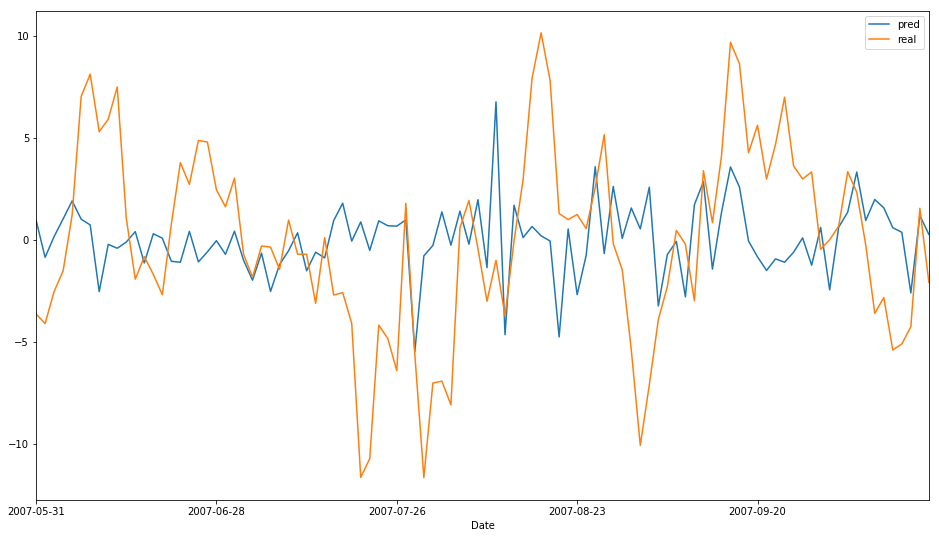


51% of the time we get the direction right

MAE TEST  : 3.75588671894
MSE TEST  : 86.5301030676


In [16]:
print_results_report(Y_pred,Y_test)

In [ ]:
plt.hist(Y_train,range=(-100,100),bins=1000)
plt.show()

In [19]:
X_train.shape

(83240, 45)

# QUICK IMPLEMENTATION NEW FEATURES

In [ ]:
df = get_df("GLE.PA.csv")

In [ ]:
import math
def ema(stock,window_size):
    '''
    input =
        - series of a stock's adjusted close
        - a window_size
    output =
        - a series of the exponential moving average
        
    IMPORTANT
    si le stock fait 
    2
    3
    nan
    3 
    4
    on fait comme si le nan n'avait jamais existé
    cela ne pose pas trop de problème parce que normalement on est sensé avoir déjà dégagé les nan
        
    '''
    k = 2./(window_size+1)
    l_return = []
    l_values = []
    for i in range(0,len(stock)-1):
        if len(l_values)==0 and not math.isnan(stock[i]):
            l_return.append(stock[i])
            l_values.append(stock[i])
        if math.isnan(stock[i]):
            l_return.append(float('nan'))
        else:
            if len(l_values)==0:
                l_return.append(stock[i])
                l_values.append(stock[i])
            else:
                ema = stock[i]*k+l_values[-1]*(1-k)
                l_return.append(ema)
                l_values.append(ema)
    return pd.Series(l_return,index=stock.index)

In [ ]:
high = df['High'].rolling(window=14).max()
low = df['Low'].rolling(window=14).min()
df['C'] = (high+low)/2
df['H'] = df['Close'] - df['C']

ema(df['H'],14)

df['HS1'] = ema(df['H'],14)
df['HS2'] = ema(df['HS1'],14)
df['DHL1'] = ema(high-low,14)
df['DHL2'] = ema(df['DHL1'],14)
df['SMI'] = 100*df['HS2']/df['DHL2']

df.head(100)



# QUICK TEST NEW FEATURES

In [ ]:
%run ./feature_engineering.py
%run ./utils.py

In [ ]:
GLE = build_df("GLE.PA.csv")

In [ ]:
for column in GLE.columns:
    print column